<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ). 

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение. 
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов. 

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import QuantileTransformer
! pip install diffusers
from diffusers import DDPMScheduler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [ ]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("https://raw.githubusercontent.com/hse-ds/iad-applied-ds/master/2023/hw/hw1/data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [ ]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [ ]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [ ]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [ ]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [ ]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

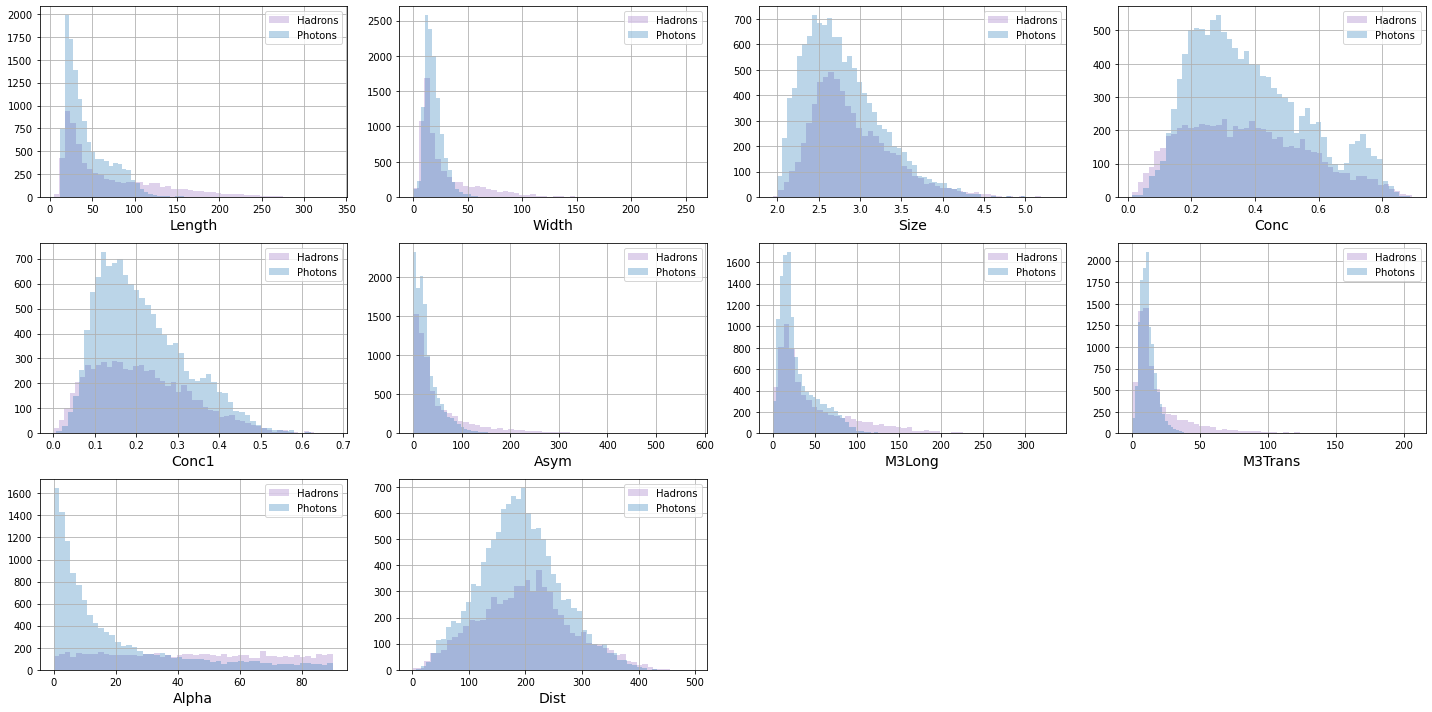

In [ ]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [ ]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

In [ ]:
def plot_pies(y, label1, label2):
    plt.figure(figsize=(3, 4))
    plt.pie([(y == 0).sum(), (y == 1).sum()],colors=['C4', 'C0'], wedgeprops={"alpha": 0.3})
    plt.xlabel(names[-1], size=14)
    plt.legend(labels=[label1, label2],loc="best")
    plt.tight_layout()

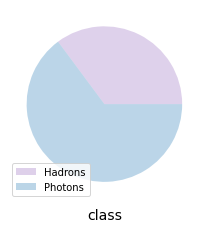

In [ ]:
plot_pies(
    y_train.reshape(1,len(y_train))[0], label1="Hadrons", label2="Photons")

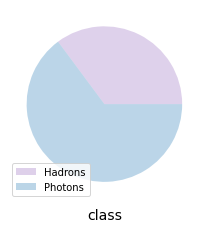

In [ ]:
plot_pies(
    y_test, label1="Hadrons", label2="Photons")

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [ ]:
### YOUR CODE IS HERE ######
qt = QuantileTransformer(random_state=11, output_distribution = 'normal')
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)
### THE END OF YOUR CODE ###

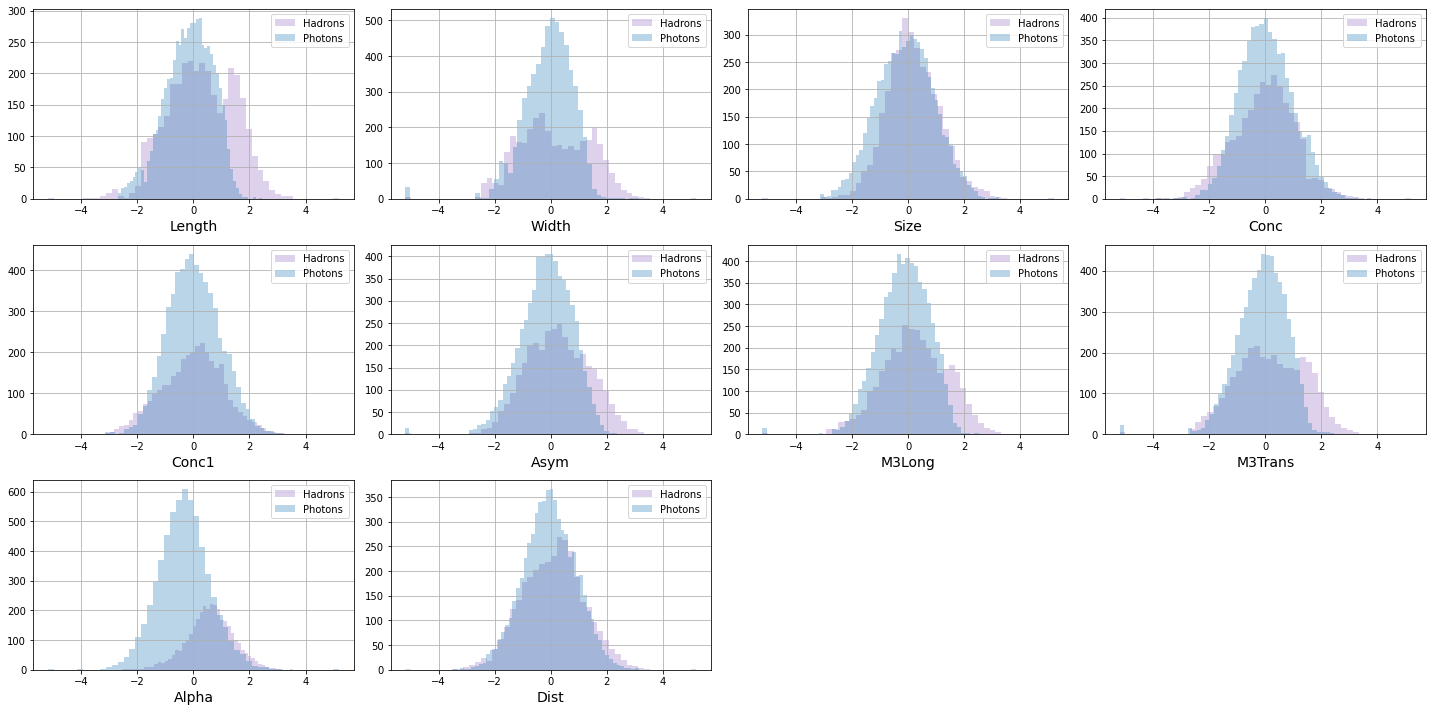

In [ ]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

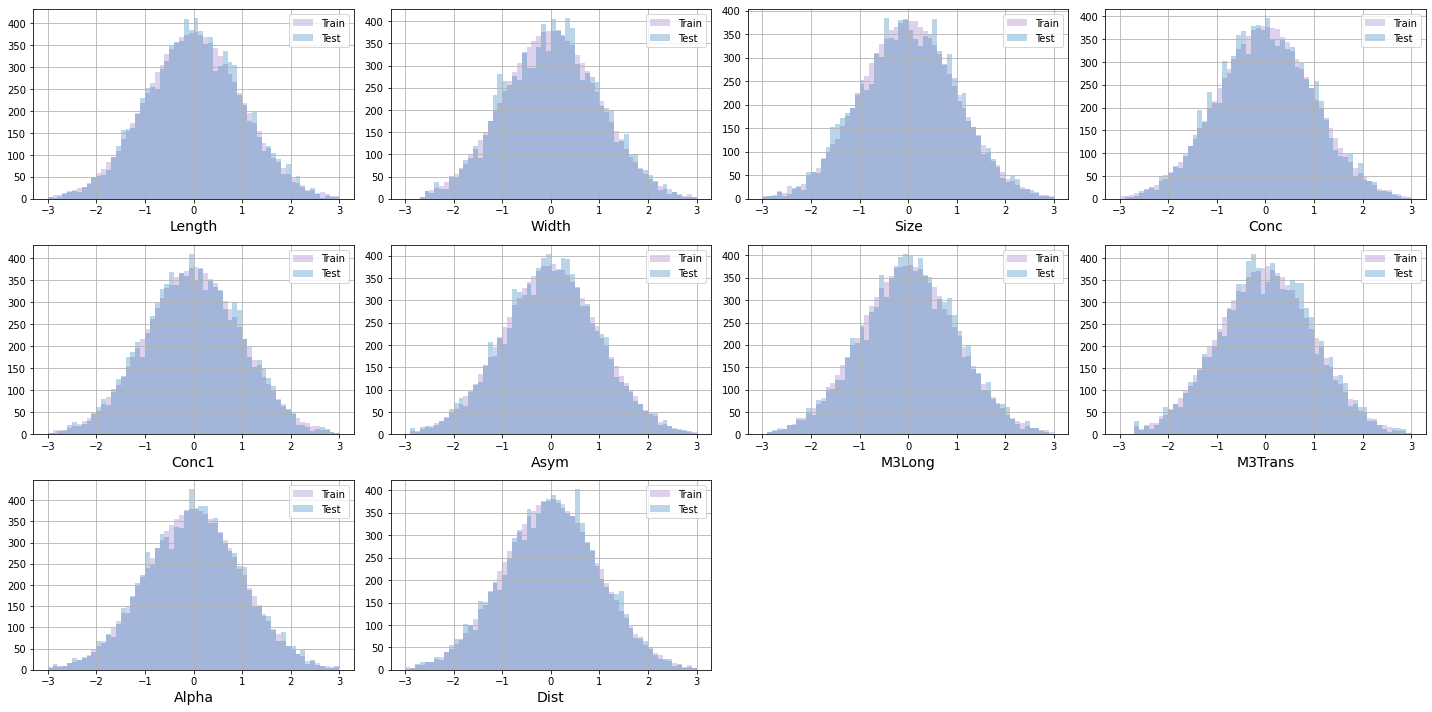

In [ ]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения. 

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
DEVICE

device(type='cuda')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [ ]:
from torch.nn.modules.batchnorm import BatchNorm1d
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [ ]:
def generate(generator, y, latent_dim):
    # z = torch.normal(0, 1, (len(y), latent_dim))
    z = torch.distributions.Normal(torch.zeros(latent_dim).to(device=DEVICE), torch.ones(latent_dim).to(device=DEVICE)).sample((y.shape[0],))
    generator = generator.to(DEVICE)
    X_fake = generator(z, y)
    return X_fake.cpu().detach().numpy()  # numpy

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

Кажется, что функции активации быть не должно, так как обучаемся на лосс без логарифмов: считать лосс, сладывая/вычитая нолики и единички - сомнительная идея: он будет очень маленький и, скорее всего, градиенты затухнут и мы не обучимся (будем болтаться около 0). Если убрать сигмоиду, то у нас будут а-ля матожидания, они побольше и сравнивать их основательнее.

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель линейной регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
def other_agent_score(X_real, y_real, X_fake, y_fake):

    X = np.append(X_real.cpu().detach().numpy(), X_fake.cpu().detach().numpy(), axis=0)
    y = np.append(y_real.cpu().detach().numpy(), y_fake.cpu().detach().numpy(), axis=0)

    X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.25, shuffle = True, random_state = 11)

    logreg = LogisticRegression().fit(X_train, y_train)
    boost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.8, max_depth=1, random_state=0).fit(X_train, y_train)

    log_reg_score = logreg.score(X_test, y_test)
    boosting_score = boost.score(X_test, y_test)

    print('Logistic regression score: ' + str(log_reg_score))
    print('Boosting score: ' + str(boosting_score))

Наше идеальное аккураси = 0.5. Предположим, что у нас есть 50 реальных (единички) и 50 фейковых объектов (нолики) (всего 100). Мы делаем на них 100 предиктов и хотим предсказывать так, чтобы и на реальных объектах мы выдавали единички, и на фейковых (в ганах задача обратная - обмануть дискриминатор, чтобы он не отличил фейки от реальных объектов). Тогда наше аккураси будет 50/100 = 0.5.

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Подсказка 1: не забывайте ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора.
- Подсказка 2: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 3: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [ ]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []
        self.loss_history_gen = []
        self.loss_generator = []
        self.loss_discriminator = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                real_objects = real_batch.to(DEVICE)
                cond_batch = cond_batch.to(DEVICE)
                # real_objects = real_objects.to(device)
                
                num_objects = real_objects.shape[0]
                z = torch.distributions.Normal(torch.zeros(latent_dim).to(device=DEVICE), torch.ones(latent_dim).to(device=DEVICE)).sample((num_objects,))
                gen_objects = self.generator(z,cond_batch)

                if i % self.n_critic == 0:

                  self.opt_gen.zero_grad()
                  gen_loss = - torch.mean(self.discriminator(gen_objects, cond_batch))
                  gen_loss.backward()
                  self.opt_gen.step()
                  self.loss_generator.append(gen_loss.detach().cpu())
                  
                else:
              
                  self.opt_disc.zero_grad()
                  discr_loss = - torch.mean(self.discriminator(real_objects, cond_batch)) + torch.mean(self.discriminator(gen_objects, cond_batch))
                  discr_loss.backward()
                  self.opt_disc.step()
                  self.loss_discriminator.append(discr_loss.detach().cpu())
                  for p in self.discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)
    
            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise.to(device=DEVICE), y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
        

            self.loss_history.append(loss_epoch.detach().cpu())
            

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов 
            # И запустите работу фукнции other_agent_score

            X_real_sample = X_real[:1000,]
            y_sample = torch.ones(1000)
            X_fake_sample = X_fake[:1000,:]
            y_fake_sample = torch.zeros(1000)
            other_agent_score(X_real_sample, y_sample, X_fake_sample, y_fake_sample)
            
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [ ]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

Logistic regression score: 0.726
Boosting score: 0.964
Logistic regression score: 0.698
Boosting score: 0.926
Logistic regression score: 0.648
Boosting score: 0.882
Logistic regression score: 0.598
Boosting score: 0.798
Logistic regression score: 0.508
Boosting score: 0.776
Logistic regression score: 0.586
Boosting score: 0.758
Logistic regression score: 0.556
Boosting score: 0.736
Logistic regression score: 0.598
Boosting score: 0.734
Logistic regression score: 0.538
Boosting score: 0.682
Logistic regression score: 0.558
Boosting score: 0.682
Logistic regression score: 0.578
Boosting score: 0.67
Logistic regression score: 0.552
Boosting score: 0.608
Logistic regression score: 0.52
Boosting score: 0.57
Logistic regression score: 0.596
Boosting score: 0.652
Logistic regression score: 0.54
Boosting score: 0.57
Logistic regression score: 0.582
Boosting score: 0.614
Logistic regression score: 0.56
Boosting score: 0.608
Logistic regression score: 0.506
Boosting score: 0.568
Logistic regress

<ipython-input-89-684ea810ad15>:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")


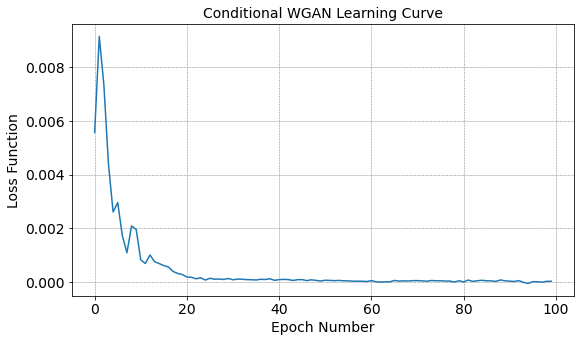

In [ ]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [ ]:
X_train_inv = qt.inverse_transform(X_train)
X_test_inv = qt.inverse_transform(X_test)

y_train = torch.tensor(y_train, dtype=torch.float, device=DEVICE)
y_test = torch.tensor(y_test, dtype=torch.float, device=DEVICE)

X_fake_train = qt.inverse_transform(generate(fitter.generator, y_train, latent_dim))
X_fake_test = qt.inverse_transform((generate(fitter.generator, y_test, latent_dim)))

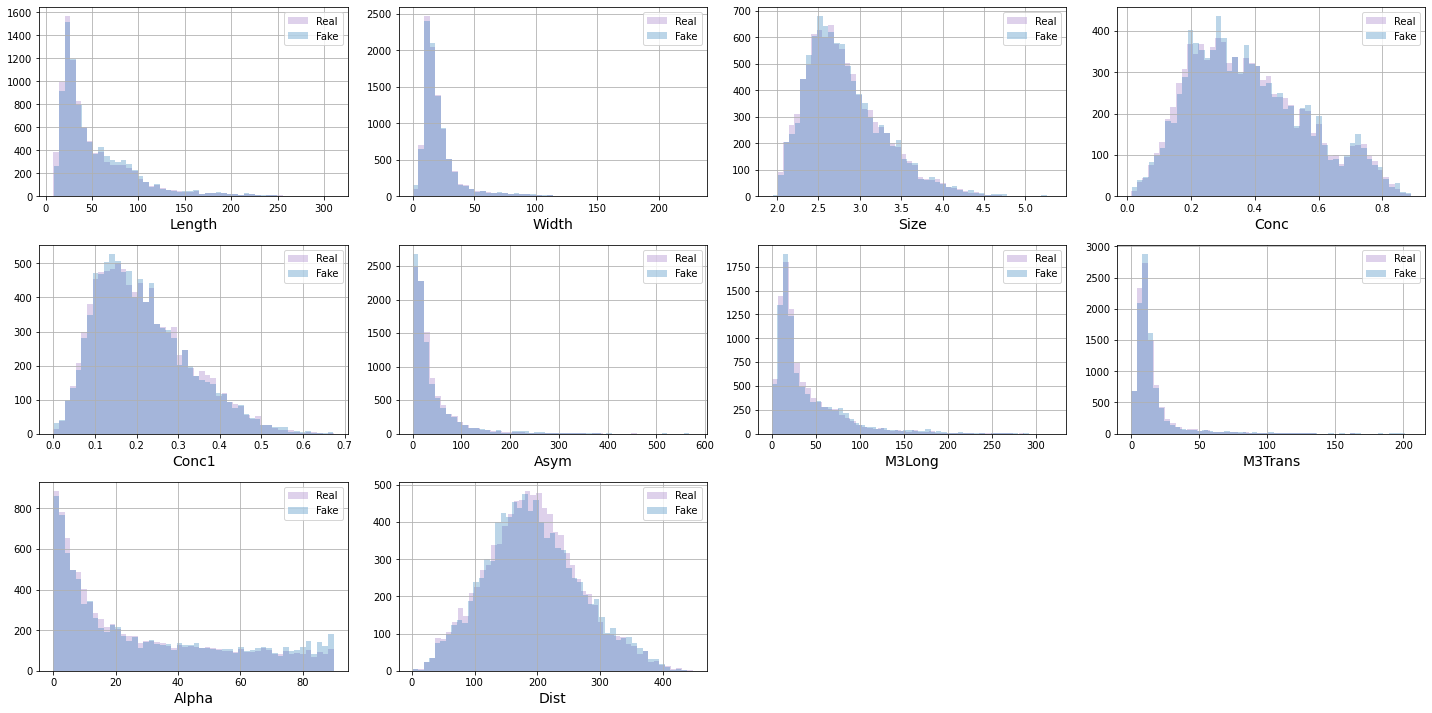

In [ ]:
plot_hists(X_train_inv, X_fake_train, names, label1="Real", label2="Fake", bins=50)

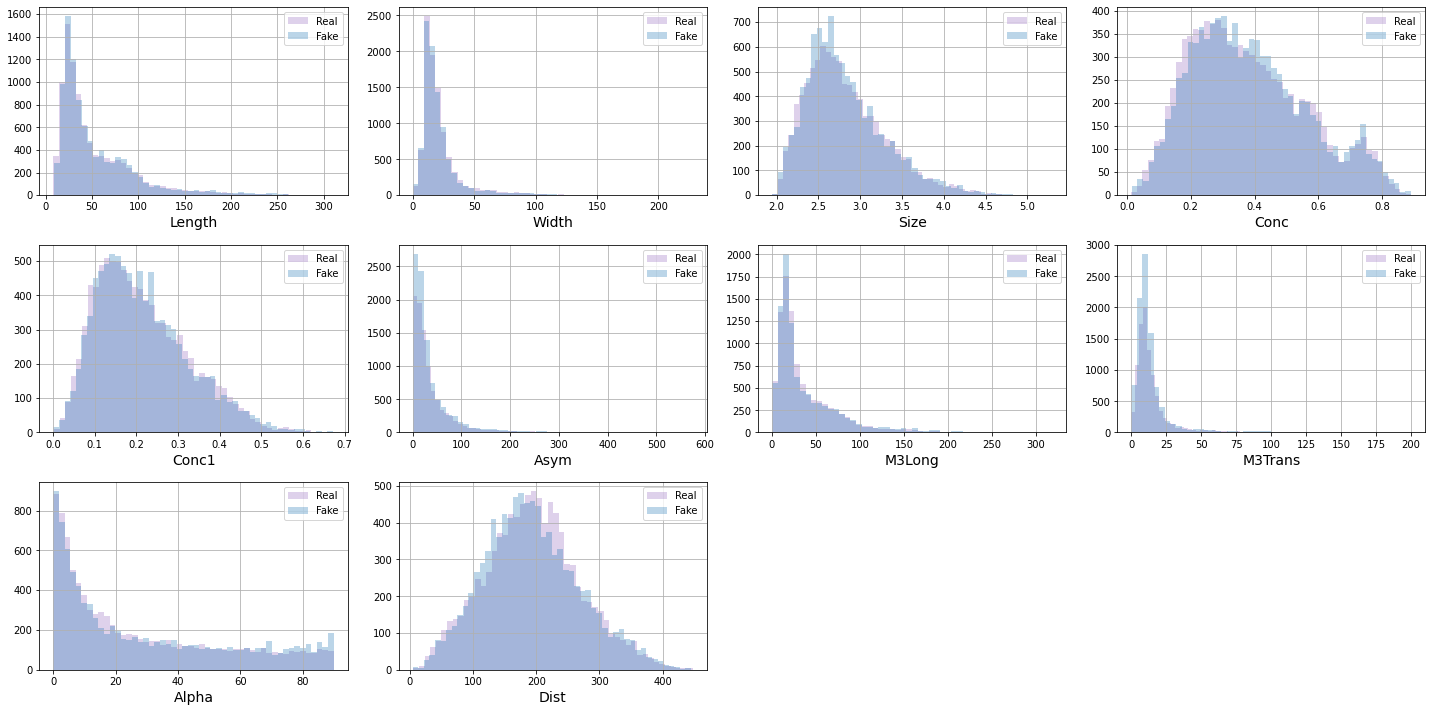

In [ ]:
plot_hists(X_test_inv, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод: 
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [ ]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train_inv), axis=0)
XX_test = np.concatenate((X_fake_test, X_test_inv), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7054747119916939


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


**Что сделали**

1.  Написали генератор (с вектором условия): на выходе - сгенерированные объекты (их признаки). Loss = - torch.mean(self.discriminator(gen_objects, cond_batch)), где gen_objects = self.generator(z, cond_batch), z - нормальный шум. Лосс минимизируем: чем больше аутпут (т.е. чем больше фейковый объект похож на реальный, тем меньше лосс, т.е. пытаемся обмануть дискриминатор.
2.  Написали дискриминатор (с вектором условия): на выходе - класс (а точнее какое-то число, не используем сигмоиду). Loss = - torch.mean(self.discriminator(real_objects, cond_batch)) + torch.mean(self.discriminator(gen_objects, cond_batch)), где gen_objects = self.generator(z, cond_batch), z - нормальный шум. Лосс минимизируем по дискриминатору и максимизируем по генератору: дискриминатор пытемся разделить фейки от реальных данных, при этом генератор мешает ему это сделать.

На 5 шагов дискриминатора обучаем 1 генератор. 

3.  Финальная метрика качества - torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(self.discriminator(X_fake, y_cond)) - разница между аутпутами дискриминатора на реальных и фейковых данных, т.е. насколько они близки. 
4. Генерим данные и обучаем регрессию с бустингом на каждой эпохе, смотрим их скоры (в идеале должны быть в районе 0.5). В целом, аккураси падает бодро.
5. После обучения дискриминатора и герератора генерим фейки и обучаем бустинг. Смотрим аук рок. Значение в районе 0.7 (в идеале должно быть 0.5, т.е. модель должна плохо "упорядочивать" объекты разных классов). В целом, с учетом довольно простой архитектуры сеток генератора и дискриминатора, все не так печально.






## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [ ]:
def corrupt(x, amount):

    noise = torch.rand_like(x)
    #amount = amount.view(x.shape[0], x.shape[1]) # можно разные генерить, но так аук выше
    amount = amount.view(-1, 1)
    x = x * (1 - amount) + noise * amount
    return x

## Добавим sсheduler, он пригодится вам при обучении модели

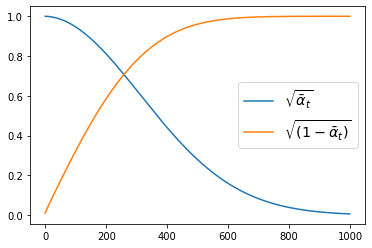

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample=True, clip_sample_range = 3)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?). 

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

Качество будем мерить с помощью MSE: в зависимости от предикта сравнивать шум, добавленный на шаге t (предикт) с реальным шумом на шаге t / предикт  объекта с реальным объектом.

In [ ]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )  

    def forward(self, z, y):
        zy = torch.cat((z,y), dim=1)
        return self.net(zy)

In [ ]:
class DiffusionGenerator_scheduler(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator_scheduler, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_inputs + 1, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )  

    def forward(self, z, t, y):
        zty = torch.cat((z, t, y), dim=1) # добавляем timesteps - t
        return self.net(zty)


## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

Напишем 2 версии - с corrupt и шедулером

In [ ]:
import tqdm
from tqdm.auto import tqdm

In [ ]:
def generate_with_diffusion_scheduler(model, y, latent_dim, sheduler):
   

   noise = torch.randn(y.shape[0], 10).to(DEVICE)
   timesteps = torch.randint(0, 999, (y.shape[0],)).long().to(DEVICE)
   y = y.to(DEVICE)
   model = model.to(DEVICE)
   #timesteps = torch.reshape(timesteps, (noise.shape[0], 1))

   for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
     with torch.no_grad():
       tt= torch.unsqueeze(torch.tensor(t.item()).repeat(y.shape[0]), dim=1).to(DEVICE)
       residual = model(noise, tt, y).to(DEVICE)
     residual = noise_scheduler.step(residual, t, noise).prev_sample
    
   return residual.cpu().numpy()  # numpy

In [ ]:
def generate_with_diffusion_corrupt(model, y, latent_dim):
  
   n_steps = 50
   x = torch.randn(y.shape[0], latent_dim).to(DEVICE)
   for i in range(n_steps):
     with torch.no_grad():
       pred = model(x, y)
     mix_factor = 1 / (n_steps - i)
     x = x * (1 - mix_factor) + pred * mix_factor
    
   return x.cpu().numpy()  # numpy

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

Сначала попробуем с шедулером

In [ ]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        scheduler,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)
        self.scheduler = scheduler

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                real_batch = real_batch.to(DEVICE)
                cond_batch = cond_batch.to(DEVICE)

                noise = torch.randn_like(real_batch)
                timesteps = torch.randint(0, 999, (real_batch.shape[0],)).long().to(DEVICE)
                noisy_x = self.scheduler.add_noise(real_batch, noise, timesteps)

                timesteps = torch.reshape(timesteps, (real_batch.shape[0], 1))

                pred = self.model(noisy_x, timesteps, cond_batch)

                L = nn.MSELoss()

                loss = L(pred, noise)
                
                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()
                
                loss_epoch += loss.item()

                
                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch
            
            self.loss_history.append(loss_epoch)
            
            X_real_sample = X_real[:1000,]
            y_sample = torch.ones(1000)
            # y_fake_sample = torch.zeros(1000).float().reshape((1000,1))
            X_fake_sample = generate_with_diffusion_scheduler(self.model, y_cond, latent_dim, self.scheduler)[:1000,]
            y_fake = torch.zeros(1000)
       
            
            other_agent_score(X_real_sample, y_sample, X_fake_sample, y_fake)
            
            
            
        # Turn off training
        self.model.train(False)

In [ ]:
def other_agent_score(X_real, y_real, X_fake, y_fake):

    X = np.append(X_real.cpu().detach().numpy(), X_fake, axis=0)
    y = np.append(y_real.cpu().detach().numpy(), y_fake.detach().numpy(), axis=0)

    X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.25, shuffle = True, random_state = 11)

    logreg = LogisticRegression().fit(X_train, y_train)

    boost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.8, max_depth=1, random_state=0).fit(X_train, y_train)

    log_reg_score = logreg.score(X_test, y_test)
    boosting_score = boost.score(X_test, y_test)

    print('Linear regression score: ' + str(log_reg_score))
    print('Boosting score: ' + str(boosting_score))

In [ ]:
%%time
latent_dim = 10
model = DiffusionGenerator_scheduler(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
scheduler = noise_scheduler

diffusionFitter = DiffusionFitter(
    model,
    scheduler,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

0it [00:00, ?it/s]

Linear regression score: 0.554
Boosting score: 0.55


0it [00:00, ?it/s]

Linear regression score: 0.51
Boosting score: 0.516


0it [00:00, ?it/s]

Linear regression score: 0.53
Boosting score: 0.526


0it [00:00, ?it/s]

Linear regression score: 0.514
Boosting score: 0.49


0it [00:00, ?it/s]

Linear regression score: 0.49
Boosting score: 0.488


0it [00:00, ?it/s]

Linear regression score: 0.512
Boosting score: 0.45


0it [00:00, ?it/s]

Linear regression score: 0.532
Boosting score: 0.48


0it [00:00, ?it/s]

Linear regression score: 0.508
Boosting score: 0.532


0it [00:00, ?it/s]

Linear regression score: 0.512
Boosting score: 0.498


0it [00:00, ?it/s]

Linear regression score: 0.482
Boosting score: 0.518


0it [00:00, ?it/s]

Linear regression score: 0.494
Boosting score: 0.484


0it [00:00, ?it/s]

Linear regression score: 0.486
Boosting score: 0.468


0it [00:00, ?it/s]

Linear regression score: 0.506
Boosting score: 0.526


0it [00:00, ?it/s]

Linear regression score: 0.506
Boosting score: 0.476


0it [00:00, ?it/s]

Linear regression score: 0.478
Boosting score: 0.51


0it [00:00, ?it/s]

Linear regression score: 0.482
Boosting score: 0.486


0it [00:00, ?it/s]

Linear regression score: 0.54
Boosting score: 0.488


0it [00:00, ?it/s]

Linear regression score: 0.502
Boosting score: 0.49


0it [00:00, ?it/s]

Linear regression score: 0.552
Boosting score: 0.482


0it [00:00, ?it/s]

Linear regression score: 0.494
Boosting score: 0.464


0it [00:00, ?it/s]

Linear regression score: 0.506
Boosting score: 0.502


0it [00:00, ?it/s]

Linear regression score: 0.514
Boosting score: 0.492


0it [00:00, ?it/s]

Linear regression score: 0.51
Boosting score: 0.5


0it [00:00, ?it/s]

Linear regression score: 0.48
Boosting score: 0.502


0it [00:00, ?it/s]

Linear regression score: 0.502
Boosting score: 0.516


0it [00:00, ?it/s]

Linear regression score: 0.48
Boosting score: 0.492


0it [00:00, ?it/s]

Linear regression score: 0.522
Boosting score: 0.522


0it [00:00, ?it/s]

Linear regression score: 0.464
Boosting score: 0.494


0it [00:00, ?it/s]

Linear regression score: 0.546
Boosting score: 0.478


0it [00:00, ?it/s]

Linear regression score: 0.512
Boosting score: 0.474


0it [00:00, ?it/s]

Linear regression score: 0.512
Boosting score: 0.49


0it [00:00, ?it/s]

Linear regression score: 0.542
Boosting score: 0.502


0it [00:00, ?it/s]

Linear regression score: 0.528
Boosting score: 0.48


0it [00:00, ?it/s]

Linear regression score: 0.514
Boosting score: 0.49


0it [00:00, ?it/s]

Linear regression score: 0.514
Boosting score: 0.508


0it [00:00, ?it/s]

Linear regression score: 0.494
Boosting score: 0.514


0it [00:00, ?it/s]

Linear regression score: 0.534
Boosting score: 0.522


0it [00:00, ?it/s]

Linear regression score: 0.53
Boosting score: 0.51


0it [00:00, ?it/s]

Linear regression score: 0.594
Boosting score: 0.536


0it [00:00, ?it/s]

Linear regression score: 0.52
Boosting score: 0.508


0it [00:00, ?it/s]

Linear regression score: 0.526
Boosting score: 0.524


0it [00:00, ?it/s]

Linear regression score: 0.496
Boosting score: 0.49


0it [00:00, ?it/s]

Linear regression score: 0.498
Boosting score: 0.516


0it [00:00, ?it/s]

Linear regression score: 0.516
Boosting score: 0.484


0it [00:00, ?it/s]

Linear regression score: 0.532
Boosting score: 0.524


0it [00:00, ?it/s]

Linear regression score: 0.492
Boosting score: 0.478


0it [00:00, ?it/s]

Linear regression score: 0.51
Boosting score: 0.466


0it [00:00, ?it/s]

Linear regression score: 0.532
Boosting score: 0.512


0it [00:00, ?it/s]

Linear regression score: 0.526
Boosting score: 0.488


0it [00:00, ?it/s]

Linear regression score: 0.484
Boosting score: 0.53


0it [00:00, ?it/s]

Linear regression score: 0.496
Boosting score: 0.484


0it [00:00, ?it/s]

Linear regression score: 0.47
Boosting score: 0.482


0it [00:00, ?it/s]

Linear regression score: 0.512
Boosting score: 0.498


0it [00:00, ?it/s]

Linear regression score: 0.472
Boosting score: 0.506


0it [00:00, ?it/s]

Linear regression score: 0.484
Boosting score: 0.478


0it [00:00, ?it/s]

Linear regression score: 0.488
Boosting score: 0.48


0it [00:00, ?it/s]

Linear regression score: 0.484
Boosting score: 0.508


0it [00:00, ?it/s]

Linear regression score: 0.542
Boosting score: 0.54


0it [00:00, ?it/s]

Linear regression score: 0.508
Boosting score: 0.476


0it [00:00, ?it/s]

Linear regression score: 0.492
Boosting score: 0.528


0it [00:00, ?it/s]

Linear regression score: 0.492
Boosting score: 0.492


0it [00:00, ?it/s]

Linear regression score: 0.54
Boosting score: 0.492


0it [00:00, ?it/s]

Linear regression score: 0.496
Boosting score: 0.48


0it [00:00, ?it/s]

Linear regression score: 0.508
Boosting score: 0.508


0it [00:00, ?it/s]

Linear regression score: 0.478
Boosting score: 0.496


0it [00:00, ?it/s]

Linear regression score: 0.552
Boosting score: 0.474


0it [00:00, ?it/s]

Linear regression score: 0.552
Boosting score: 0.544


0it [00:00, ?it/s]

Linear regression score: 0.514
Boosting score: 0.508


0it [00:00, ?it/s]

Linear regression score: 0.56
Boosting score: 0.496


0it [00:00, ?it/s]

Linear regression score: 0.506
Boosting score: 0.464


0it [00:00, ?it/s]

Linear regression score: 0.52
Boosting score: 0.49


0it [00:00, ?it/s]

Linear regression score: 0.51
Boosting score: 0.514


0it [00:00, ?it/s]

Linear regression score: 0.49
Boosting score: 0.514


0it [00:00, ?it/s]

Linear regression score: 0.482
Boosting score: 0.46


0it [00:00, ?it/s]

Linear regression score: 0.522
Boosting score: 0.498


0it [00:00, ?it/s]

Linear regression score: 0.502
Boosting score: 0.52


0it [00:00, ?it/s]

Linear regression score: 0.538
Boosting score: 0.506


0it [00:00, ?it/s]

Linear regression score: 0.56
Boosting score: 0.484


0it [00:00, ?it/s]

Linear regression score: 0.502
Boosting score: 0.468


0it [00:00, ?it/s]

Linear regression score: 0.51
Boosting score: 0.504


0it [00:00, ?it/s]

Linear regression score: 0.472
Boosting score: 0.462


0it [00:00, ?it/s]

Linear regression score: 0.55
Boosting score: 0.498


0it [00:00, ?it/s]

Linear regression score: 0.498
Boosting score: 0.482


0it [00:00, ?it/s]

Linear regression score: 0.52
Boosting score: 0.484


0it [00:00, ?it/s]

Linear regression score: 0.526
Boosting score: 0.472


0it [00:00, ?it/s]

Linear regression score: 0.5
Boosting score: 0.496


0it [00:00, ?it/s]

Linear regression score: 0.532
Boosting score: 0.532


0it [00:00, ?it/s]

Linear regression score: 0.476
Boosting score: 0.468


0it [00:00, ?it/s]

Linear regression score: 0.502
Boosting score: 0.498


0it [00:00, ?it/s]

Linear regression score: 0.514
Boosting score: 0.49


0it [00:00, ?it/s]

Linear regression score: 0.5
Boosting score: 0.494


0it [00:00, ?it/s]

Linear regression score: 0.526
Boosting score: 0.48


0it [00:00, ?it/s]

Linear regression score: 0.532
Boosting score: 0.492


0it [00:00, ?it/s]

Linear regression score: 0.536
Boosting score: 0.48


0it [00:00, ?it/s]

Linear regression score: 0.516
Boosting score: 0.526


0it [00:00, ?it/s]

Linear regression score: 0.51
Boosting score: 0.496


0it [00:00, ?it/s]

Linear regression score: 0.506
Boosting score: 0.506


0it [00:00, ?it/s]

Linear regression score: 0.454
Boosting score: 0.486


0it [00:00, ?it/s]

Linear regression score: 0.51
Boosting score: 0.506


0it [00:00, ?it/s]

Linear regression score: 0.53
Boosting score: 0.53
CPU times: user 23min 29s, sys: 3min 58s, total: 27min 28s
Wall time: 27min 49s


<ipython-input-23-c0916e68e8fe>:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")


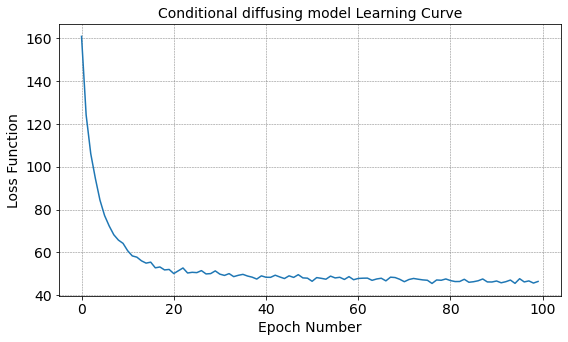

In [ ]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

Теперь попробуем с corrupt

In [ ]:
class DiffusionFitter_corrupt(object):
    def __init__(
        self,
        model,
        batch_size = 32,
        n_epochs = 10,
        latent_dim = 1,
        lr = 0.0001,
        n_critic=5,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)


    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                real_batch = real_batch.to(DEVICE)
                cond_batch = cond_batch.to(DEVICE)

                noise_amount = torch.rand(real_batch.shape[0]).to(DEVICE)
                noisy_x = corrupt(real_batch, noise_amount)

                pred = model(noisy_x, cond_batch) 

                L = nn.MSELoss()     
    
                loss = L(pred, real_batch)
                
                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()
                
                loss_epoch += loss.item()
                
                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch
            
            self.loss_history.append(loss_epoch)
            
            X_real_sample = X_real[:1000,]
            y_sample = torch.ones(1000)
            # y_fake_sample = torch.zeros(1000).float().reshape((1000,1))
            X_fake_sample = generate_with_diffusion_corrupt(self.model, y_cond[:1000,], latent_dim)
            y_fake = torch.zeros(1000)
       
            
            other_agent_score(X_real_sample, y_sample, X_fake_sample, y_fake)
            
            
            
        # Turn off training
        self.model.train(False)

In [ ]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter_corrupt = DiffusionFitter_corrupt(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter_corrupt.fit(X_train, y_train)

Linear regression score: 0.59
Boosting score: 0.724
Linear regression score: 0.484
Boosting score: 0.676
Linear regression score: 0.456
Boosting score: 0.696
Linear regression score: 0.522
Boosting score: 0.694
Linear regression score: 0.518
Boosting score: 0.646
Linear regression score: 0.534
Boosting score: 0.67
Linear regression score: 0.506
Boosting score: 0.646
Linear regression score: 0.498
Boosting score: 0.682
Linear regression score: 0.476
Boosting score: 0.672
Linear regression score: 0.51
Boosting score: 0.638
Linear regression score: 0.46
Boosting score: 0.658
Linear regression score: 0.468
Boosting score: 0.652
Linear regression score: 0.476
Boosting score: 0.656
Linear regression score: 0.506
Boosting score: 0.636
Linear regression score: 0.446
Boosting score: 0.636
Linear regression score: 0.474
Boosting score: 0.666
Linear regression score: 0.494
Boosting score: 0.636
Linear regression score: 0.498
Boosting score: 0.596
Linear regression score: 0.456
Boosting score: 0.6

<ipython-input-72-3dc97a6b81b6>:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")


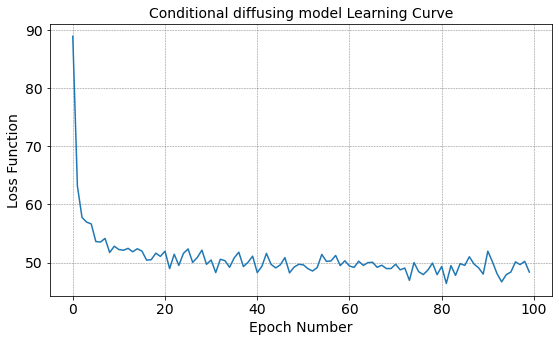

In [ ]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter_corrupt.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(b=1, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

Посмотрим на аук шедулера

In [ ]:
X_train_inv = qt.inverse_transform(X_train)
X_test_inv = qt.inverse_transform(X_test)
y_train = torch.tensor(y_train, dtype=torch.float, device=DEVICE)

In [ ]:
X_fake_train = generate_with_diffusion_scheduler(diffusionFitter.model, y_train, latent_dim, noise_scheduler)
X_fake_train = qt.inverse_transform(X_fake_train)

0it [00:00, ?it/s]

In [ ]:
y_test = torch.tensor(y_test, dtype=torch.float, device=DEVICE)
X_fake_test = generate_with_diffusion_scheduler(diffusionFitter.model, y_test, latent_dim, noise_scheduler)
X_fake_test = qt.inverse_transform(X_fake_test)

<ipython-input-31-a82336b16af9>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float, device=DEVICE)


0it [00:00, ?it/s]

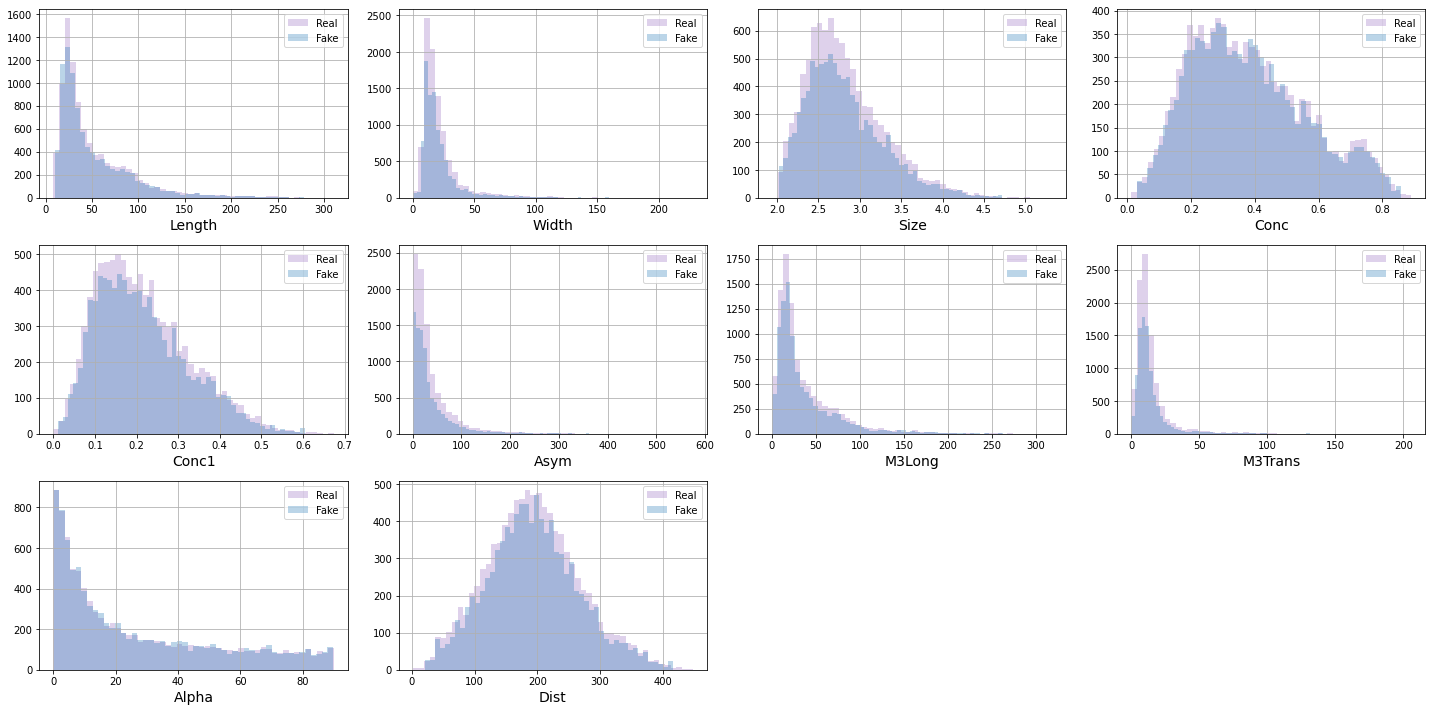

In [ ]:
plot_hists(X_train_inv, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [ ]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train_inv), axis=0)
XX_test = np.concatenate((X_fake_test, X_test_inv), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train_inv))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test_inv))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.9807112165952935


In [ ]:
X_train_inv = qt.inverse_transform(X_train)
X_test_inv = qt.inverse_transform(X_test)
y_train = torch.tensor(y_train, dtype=torch.float, device=DEVICE)

In [ ]:
X_fake_train = generate_with_diffusion_corrupt(diffusionFitter_corrupt.model, y_train, latent_dim)
X_fake_train = qt.inverse_transform(X_fake_train)

In [ ]:
y_test = torch.tensor(y_test, dtype=torch.float, device=DEVICE)
X_fake_test = generate_with_diffusion_corrupt(diffusionFitter_corrupt.model, y_test, latent_dim)
X_fake_test = qt.inverse_transform(X_fake_test)

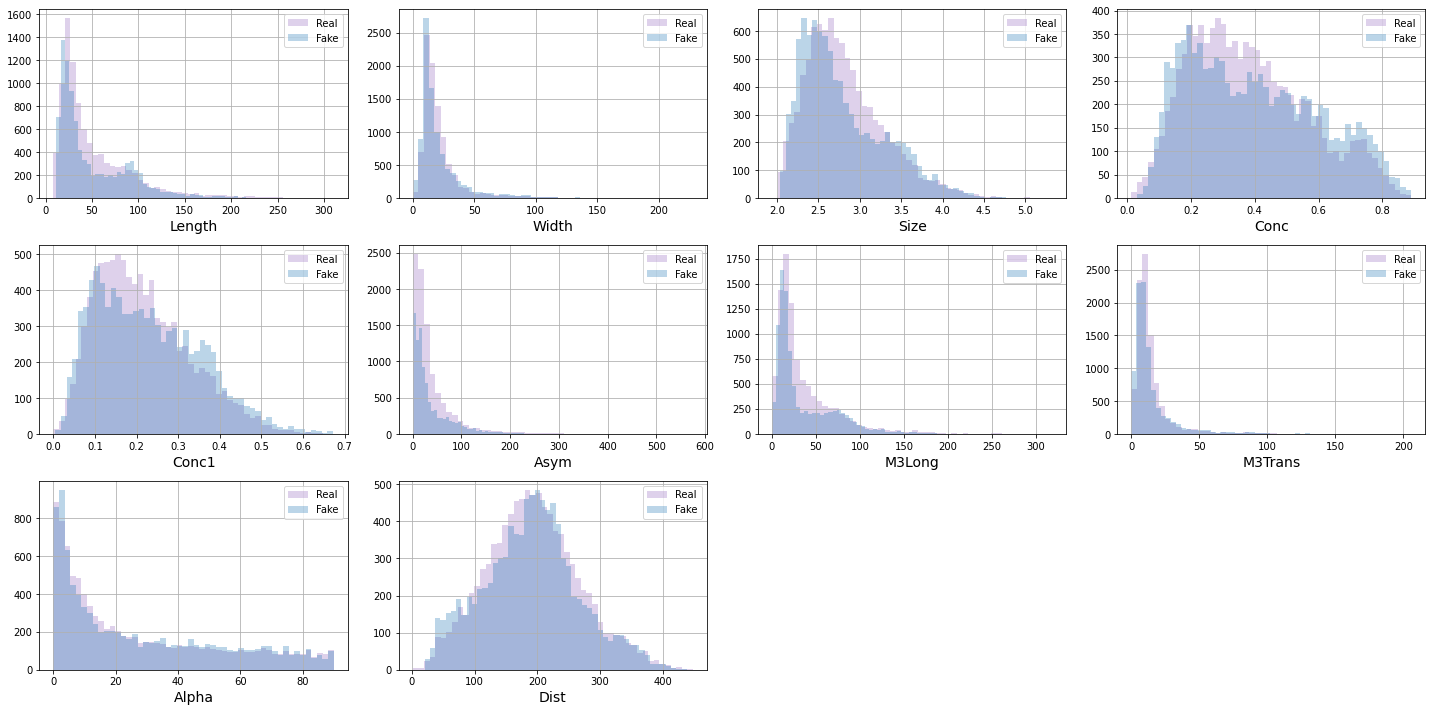

In [ ]:
plot_hists(X_train_inv, X_fake_train, names, label1="Real", label2="Fake", bins=50)

Cмотрим на коррапт

In [ ]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train_inv), axis=0)
XX_test = np.concatenate((X_fake_test, X_test_inv), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train_inv))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test_inv))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.8020275961658601


В итоге с шедулером все плохо. Наверное, модель слишком сильная для наших данных. Коррапт поппроще, поэтому обучается лучше (например, даже в срвнении с генерацией рандомной константы amount для шума получается лучше). Однако все-таки GAN работает значительно лучше, он больше подходошел под табличные данные, лучше обучился.

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!